# Frank - Wolfe for SVM Training

### Papers
   * Revisiting Frank-Wolfe: Projection-Free Sparse Convex Optimization (Jaggi, 2013)
   * On the Global Linear Convergence of Frank-Wolfe Optimization Variants (Lacoste-Julien, Jaggi, 2015)
   * An Equivalence between the Lasso and Support Vector Machines (Jaggi, 2014)
   
### Tasks
In this notebook we will implement:
   * Frank-Wolfe Algorithm
   * Away-Step Frank-Wolfe
   * Pairwise Frank-Wolfe
   * Fully Corrective Frank Wolfe
  

to train **soft-margin SVM** on the following datasets:
   * [Australian](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#australian)
   * [Breast Cancer](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#breast-cancer)
   * [Mushrooms](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#mushrooms)
   * [Phishing](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#phishing)

At the end we will compare the perfomace of the algorithms with each other.

### Integrants
Matricola, Name,  email respectively 
   * 2041509 Gita Rayung Andadari gitarayung.andadari@studenti.unipd.it

   * 2041500 Endrit Sveçla endrit.svecla@studenti.unipd.it

   * 2048722  Santiago Viquez santiago.viquezsegura@studenti.unipd.it 



## Description of the Problem

To train soft marging SVM we will formulate the optimization as follows:

$$
min_{w, \xi}  \frac{1}{2} w^{T}w + \frac{C}{2} \sum_{i=1}^{N}\xi_{i}^2
$$

$$
s.t.
$$

$$
y_{i}(wx_{i} + b)\geq 1 - \xi{i}
$$

$$
\xi{i} \geq 0
$$

This is known as the *Primal* problem.

We can transform the *primal* problem into a *dual* one by constructing the lagrangian and applying the KKT conditions. After doing so we find:

Lagrangian of the Dual Problem
$$
L_{D} = -\frac{1}{2C}\sum_{i=1}^{N}\alpha_{i}^2 - \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j}
$$

$$
s.t.
$$
$$
\alpha_{i} >= 0
\sum_{i=1}^{N}\alpha_{i} = 1
$$

Which is equivalent to:
$$
min_{\alpha} L_{D} = \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j} + \frac{1}{2C}\sum_{i=1}^{N}\alpha_{i}^2
$$

$$
s.t.
$$
$$
\alpha_{i} >= 0
$$

$$  
\sum_{i=1}^{N}\alpha_{i} = 1
$$


We will use Frank-Wolfe and variations of Frank-Wolfe to solve this minimization problem.

## Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from time import process_time_ns

## Helper Functions

### Evaluation of the Loss Function
The following function computes the Loss function (dual lagrangian $L_{D}$) 
$$
min_{\alpha} L_{D} = \frac{1}{2}\sum_{i=1}^{N}\sum_{j=1}^{N}\alpha_{i}\alpha_{j}y_{i}y_{j}x_{i}^{T}x_{j} + \frac{1}{2C}\sum_{i=1}^{N}\alpha_{i}^2
$$


In [ ]:
def loss(X, y, a, C):
    """
    Evaluates the dual lagrangian at a particular value of a (alpha)
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        a (np.array): array of the lagrange multipliers (alpha)
        C (float): Regularization parameter. The strength of the regularization 
        is inversely proportional to C. Must be strictly positive. 
        The penalty is a squared l2 penalty.

    Returns:
        loss (float): value of dual lagrangian
    """
    N = y.shape[0]
    aa = a.reshape(N,1)
    yy = y.reshape(N,1)
    term_1 = (np.matmul(yy,yy.T)*np.matmul(aa,aa.T)*np.matmul(X,X.T)).sum()
    term_2 = np.sum(a * a)
    loss = (0.5) * term_1 + (1 / (2 * C)) * term_2
    #loss = int(loss)
    return loss

### Evaluation of the Gradient
The following function evaluates the gradient of the dual lagrangian with respect to a parameter $\alpha_{i}$
$$
\nabla_{\alpha_{i}} L_{D}(\alpha) = y_{i} \sum_{j=1}^{n}\alpha_{j}y_{j}x_{i}^{T}x_{j} + \frac{\alpha_i}{C}
$$

In [ ]:
def grad(X, y, a, C):
    """
    Computes the gradient of the of the dual loss function
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        a (np.array): array of the lagrange multipliers (alpha)
        C (float): Regularization parameter. The strength of the regularization 
        is inversely proportional to C. Must be strictly positive. 
        The penalty is a squared l2 penalty.

    Returns:
        gradient (np.array): gradient of the dual lagrangian
    """
    gradients = y * np.matmul(a*y,np.matmul(X,X.T)).T + (a/C)
    #print(gradients)
    #print(a)
    return gradients 

## Optimization Algorithms

### Frank-Wolfe

In the following functions we are going to compute the *Frank-Wolf oracle* defined as:

$$
s := argmin <s, \nabla f(x^{(k)})>
$$

And perform an update:

$$
x^{k + 1} := (1 - \gamma)x^{k} + \gamma s
$$

In [ ]:
def fw_oracle(X, y, a, C):
    """
    Computes the Frank-Wolfe oracle defined as argmin(s) <s, grad(f(x))>
    where s is a feasible solution that belongs to C.
    
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        a (np.array): array of the lagrange multipliers (alpha)
        C (int): positive integer, SVM budget parameter, vertix of the FW set.
    Returns:
        s (np.array): s that minimizes argmin(s) <s, grad(f(x))>
    """
    #s = np.zeros(len(y))
    #gradient = grad(X, y, a, C)
    #abs_gradient_ = abs(gradient)
    #max_idx = np.nonzero(abs_gradient_ == max(abs_gradient_))[0][0]
    #s[max_idx] = - np.sign(gradient[max_idx]) #* C
    #return s
    
    s = np.zeros(len(y))
    gradient = grad(X, y, a, C)
    i = np.argmin(gradient)
    s[i] = 1

    #print('grad',gradient)
    return s


def fw(X, y, k, C):
    """
    Performs k Frank-Wolfe updates
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        k (int): number of iterations
        C (int): positive integer, SVM budget parameter, vertix of the FW set.
        
    Returns:
        a (np.array): lagrange multipliers that minimazes the dual lagrangian
        history (dictionary): history of the training loss
    """
    history = {}
    train_loss = 0
    a = np.ones(len(y))/len(y)
   
    for k in range(0, k):
        gamma = 2 / (k + 2)
        s = fw_oracle(X, y, a, C)
        a = (1 - gamma) * a + gamma * s

        if k % 5 == 0: 
            train_loss = loss(X, y, a, C)
            history[k] = train_loss

    return a, history

### Away-Steps Frank-Wolf

In [ ]:
def away_fw_oracle(X, y, a, S, C):
    """
    Computes the Frank-Wolfe oracle defined as argmax(s) <s, grad(f(x))>
    where s is a feasible solution.
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        a (np.array): array of the lagrange multipliers (alpha)
        C (int): positive integer, SVM budget parameter, vertix of the FW set.
    Returns:
        s (np.array): s that minimizes argmax(s) <s, grad(f(x))>
    """
    gradient = grad(X, y, a, C)
    dot = []
    for alpha in S:
        dot.append(np.dot(alpha.reshape(len(alpha), 1), gradient))

    idx = np.argmax(dot)
    v = S[idx]
    return v


def away_fw(X, y, k, C, epsilon):
    history = {}
    train_loss = 0

    a = np.ones(len(y))/len(y)
    S = [a]
    for k in range(0, k):
        if k % 5 == 0: 
            train_loss = loss(X, y, a, C)
            history[k] = train_loss
        
        s = fw_oracle(X, y, a, C)
        v = away_fw_oracle(X, y, a, S, C)
        
        if (v == S[0]).all():
            alpha = 1
        else:
            alpha = 0
        
        # FW-direction
        d_fw = s - a
        # Away-direction
        d_a = a - v
        
        g_fw = np.dot(-grad(X, y, a, C), d_fw)
        if g_fw <= epsilon:
            return a, history

        if g_fw >= np.dot(-grad(X, y, a, C), d_a):
            d = d_fw    
            gamma_max = 1
        else:
            d = d_a
            gamma_max = alpha / (1 - alpha + 0.0001)


        loss_ = loss(X, y, a, C)
        gamma_search = np.linspace(0, gamma_max, 25)
        
        for gamma_iter in gamma_search:
            tmp = loss(X, y, a + gamma_iter * d, C)
            #print('loss vs tmp',gamma_iter,tmp,loss_)
            if tmp < loss_:
                loss_ = tmp
                gamma = gamma_iter
            else:
                gamma = 0
             
        a = a + gamma * d

        if gamma == 1: 
            S=[s] 
        else: 
            check=True
            for s_check in S: 
                if (s != s_check).all():
                    check=False 
                    break 
            if check: 
                S.append(s)

        #for away step 
        #The idea is that in each iteration, we not only add a new atom s, 
        #but potentially also remove an old atom (provided it is bad with respect to our objective). 
        if gamma == gamma_max:

            eq=False 
            for s_check in S:
                if (v == s_check).all():
                    S=S.remove(v)    
            alpha =(1+gamma)*alpha
        else:
          alpha=(1+gamma)*alpha+gamma 

    return a, history

### Pairwise Frank-Wolfe

In [ ]:
def pairwise_fw(X, y, k, C, epsilon):
    history = {}
    train_loss = 0

    a = np.ones(len(y))/len(y)
    S = [a]
    for k in range(0, k):
        if k % 5 == 0: 
            train_loss = loss(X, y, a, C)
            history[k] = train_loss
        
        d = 0
        s = fw_oracle(X, y, a, C)
        v = away_fw_oracle(X, y, a, S, C)

        if (v == S[0]).all():
            alpha = 1
        else:
            alpha = 0
        
        # FW-direction
        d_fw = s - a

        if np.dot(-grad(X, y, a, C), d_fw) <= epsilon:
            return a, history

        d = s - v
        #pairwise step 
        gamma_max = alpha


        loss_ = loss(X, y, a, C)
        gamma_search = np.linspace(0, gamma_max, 25)
        
        for gamma_iter in gamma_search:
            tmp = loss(X, y, a - gamma_iter * d, C)
            if tmp < loss_:
                loss_ = tmp
                gamma = gamma_iter
            else:
                gamma = 0
             
        a = a + gamma * d

         #for frank wolve 
        if gamma == 1: 
            print('s',s)
            S=[s] 


        else: 
            check=True
            for s_check in S: 
                if (s != s_check).all():
                    check=False 
                    break 
            if check: 
                S.append(s)        


        #for away step 
        if gamma == gamma_max:

            eq=False 
            for s_check in S:
                if (v == s_check).all():
                    S=S.remove(v)    

        #pairwise 
        #We move weight  mass between two atoms in each step  
        #the difference between classical fw is that 
        #classical fw shrinks all active weight at each iteration
        
        
        alpha=alpha-gamma 

    
    return a, history

### Fully-Corrective Frank-Wolfe

In [ ]:
def fully_corrective_fw(X, y, k, C, epsilon):
    history = {}
    a = np.ones(len(y))/len(y)
    S = [a]
    for k in range(0, k):
        train_loss = loss(X, y, a, C)
        if k % 5 == 0: 
            history[k] = train_loss
        
        gamma = 2/(k+2)
        s = fw_oracle(X, y, a, C)
        #increasing the set of S 
        S.append(s)

        # FW-direction
        d_fw = s - a
        g_fw = np.dot(-grad(X, y, a, C), d_fw) 
        if g_fw <= epsilon:
            return a, history
        
        # Fully corrective step 
        # The idea is after the addition of a new atom (or search direction) s 
        # re-optimizes the objective f over all previously used atoms
        loss_list=[]
        for s_iter in S: 
            loss_list.append(loss(X, y, s_iter, C))
        
        new_idx = np.argmin(loss)
        a = S[new_idx]

        #this code is added to terminate the problem if there is only small 
        #improvement after this iteration 
        if abs(loss_list[new_idx] - train_loss) < epsilon:
            return a, history 

    return a, history

## Support Vector Machines

In [ ]:
def svm(X, y, k=10, C=1, type="hard", method="fw",epsilon=0.01):
    """
    Recovers the primal of the dual SVM loss function formulation.
    Learns the w and b of the separating hyperplane by using Frank-Wolfe
    and Frank-Wolfe variations
    
    Args:
        X (np.matrix): data matrix
        y (np.array): array of 1s, -1s representing the classification labels
        C (int): positive integer, SVM budget parameter, vertix of the FW set.
        type (string): can be hard or soft depending of the desiared margin
        method (string): optimization algorithm. Can be fw, away_fw,
        pairwise_fw, fully_corrective_fw
        k (int): positive integer, number of iteration 
    Returns:
        w (np.array): w vector of the separating hyperplane
        b (int): intercept
        history (dictionary): history of the training loss
    """
    
    if method == "fw":
        alpha, history = fw(X, y, k, C)
    if method == "away_fw":
        alpha, history = away_fw(X, y, k, C, epsilon)
    if method == "pairwise_fw":
        alpha, history = pairwise_fw(X, y, k, C, epsilon)
    if method == "fully_corrective_fw":
        alpha, history = fully_corrective_fw(X, y, k, C, epsilon)

    w = np.dot(alpha.T * y , X)
    chi = alpha / C 

    b = (1 - chi) / y - np.dot(w, X.T)
    b=b.T

    b = np.mean(b[np.where(alpha > 0.00001)])

    
    return w, b, history, alpha


def predict(X, w, b):
  y_hat = np.sign(np.dot(w,X.T) + np.full(X.shape[0],b))
  return np.array(y_hat)[0]


def accuracy(y, y_hat):
  acc = abs(y_hat[y_hat == y]).sum() / len(y) * 100
  return acc



## Experiments

In [ ]:
def compare_methods(X_train, y_train, X_test, y_test, k=100):

  comparison_dict = {}
  methods = ["fw", "away_fw", "pairwise_fw", "fully_corrective_fw"]
  for method in methods:
    start_time = process_time_ns()
    w, b, history, chi = svm(X_train, y_train, C=0.5, k=k, type="soft", method=method)
    finish_time = (process_time_ns() - start_time) / 1e9
    y_hat = predict(X_test, w, b)
    acc = accuracy(y_test, y_hat)
    f1 = f1_score(y_test, y_hat)


    comparison_dict[method] = {"training_time": finish_time, "test_accuracy": acc, "test_f1": f1} 

  return comparison_dict


sns.set_theme(style="whitegrid")
sns.set_context("paper")
sns.set(font_scale=1.5)
def plot_methods_comparison(dataset_name, comparison_dict):
  
  methods = ["fw", "away_fw", "pairwise_fw", "fully_corrective_fw"]
  
  fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(24, 12))
  for method in methods:
    axes[0].bar(method, comparison_dict[method]["training_time"])
    axes[1].bar(method, comparison_dict[method]["test_accuracy"])
    axes[2].bar(method, comparison_dict[method]["test_f1"])
  
  axes[0].set_title(f"Training time - Dataset: {dataset_name}")
  axes[0].set_ylabel("time [s]")
  axes[0].tick_params(axis='x', rotation=45)
  
  axes[1].set_title(f"Test Accuracy - Dataset: {dataset_name}")
  axes[1].set_ylabel("accuracy [%]")
  axes[1].tick_params(axis='x', rotation=45)

  axes[2].set_title(f"Test F1-Score - Dataset: {dataset_name}")
  axes[2].set_ylabel("F1-score")
  axes[2].tick_params(axis='x', rotation=45)
  
  plt.show()

### Dataset: Australian
Number of classes: 2

Training Samples: 483

Test Samples: 207

Number of features: 14

In [ ]:
# Load the dataset
X, y = load_svmlight_file("/australian_scale.txt")
X = X.todense()

# Split it into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

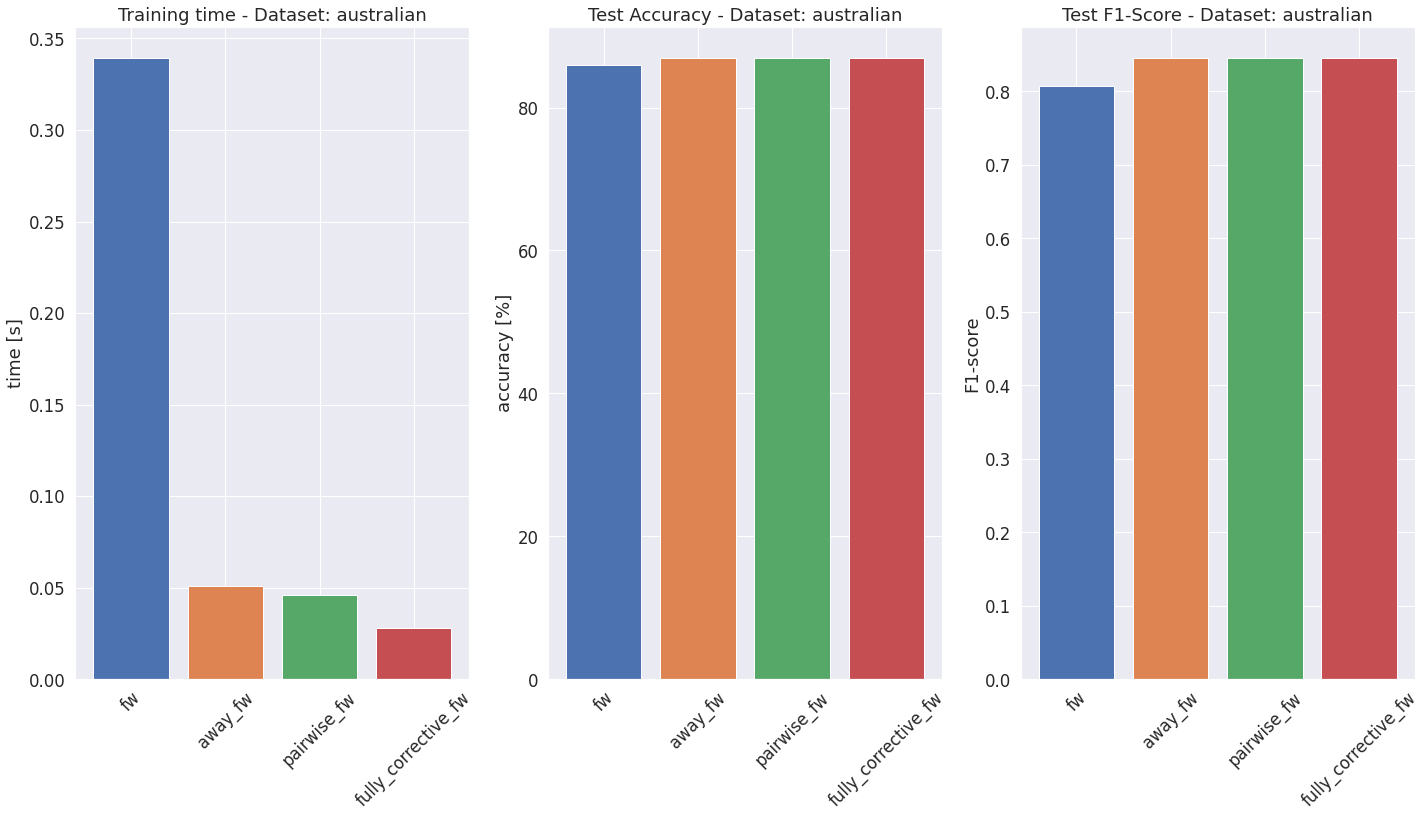

In [ ]:
comparison_dict_australian = compare_methods(X_train, y_train, X_test, y_test, k=30)
plot_methods_comparison("australian", comparison_dict_australian)

### Dataset: Breast Cancer
Number of classes: 2

Training Samples: 478

Test Samples: 205

Number of features: 10

In [ ]:
# Load the dataset
X, y = load_svmlight_file("/breast-cancer_scale.txt")
X = X.todense()

y[y == 2] = 1
y[y == 4] = -1

# Split it into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

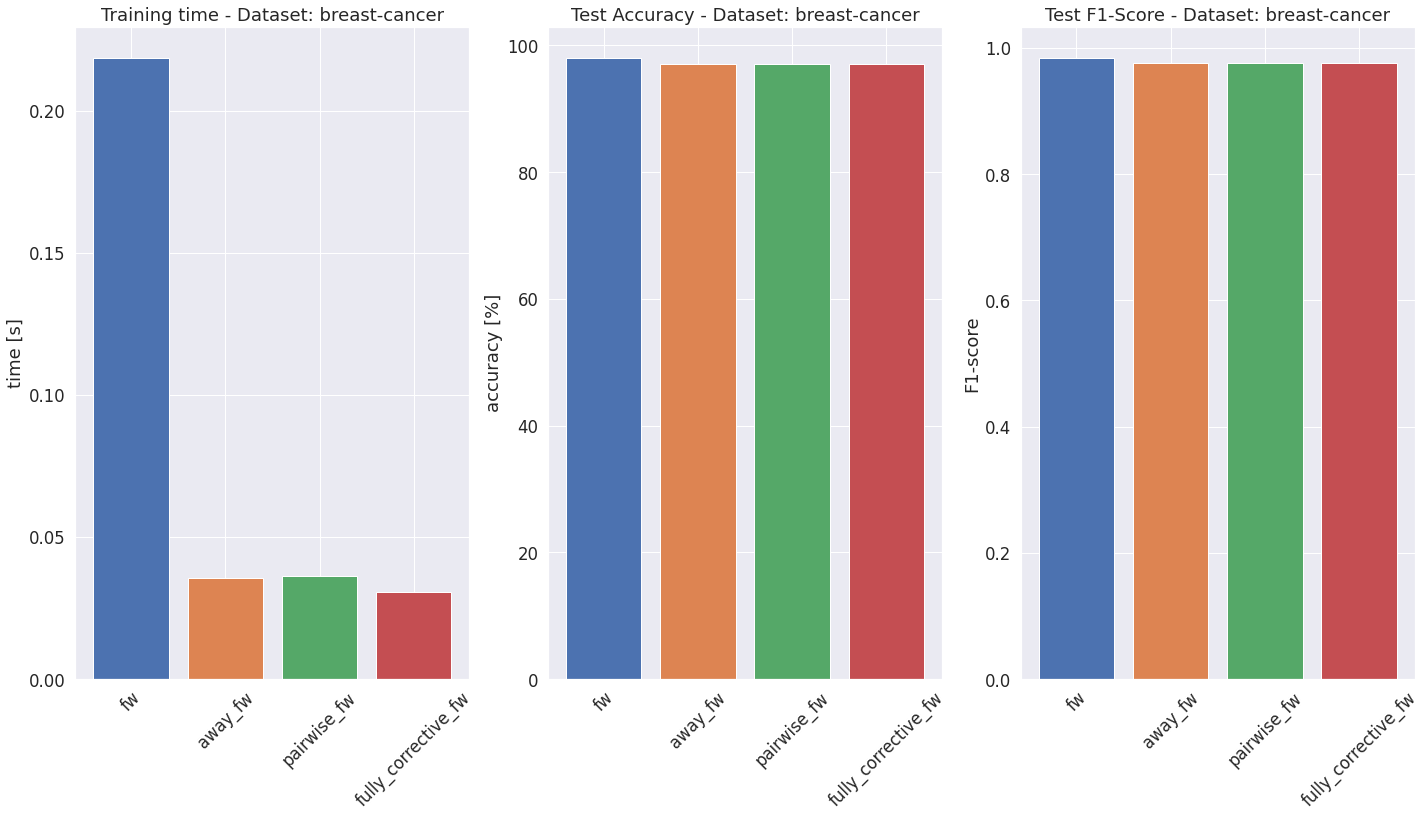

In [ ]:
comparison_dict_cancer = compare_methods(X_train, y_train, X_test, y_test, k=30)
plot_methods_comparison("breast-cancer", comparison_dict_cancer)

### Dataset: mushrooms
Number of classes: 2

Training Samples: 5686

Test Samples: 2438

Number of features: 112

In [ ]:
# Load the dataset
X, y = load_svmlight_file("/mushrooms.txt")
X = X.todense()

y[y == 1] = 1
y[y == 2] = -1

# Split it into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

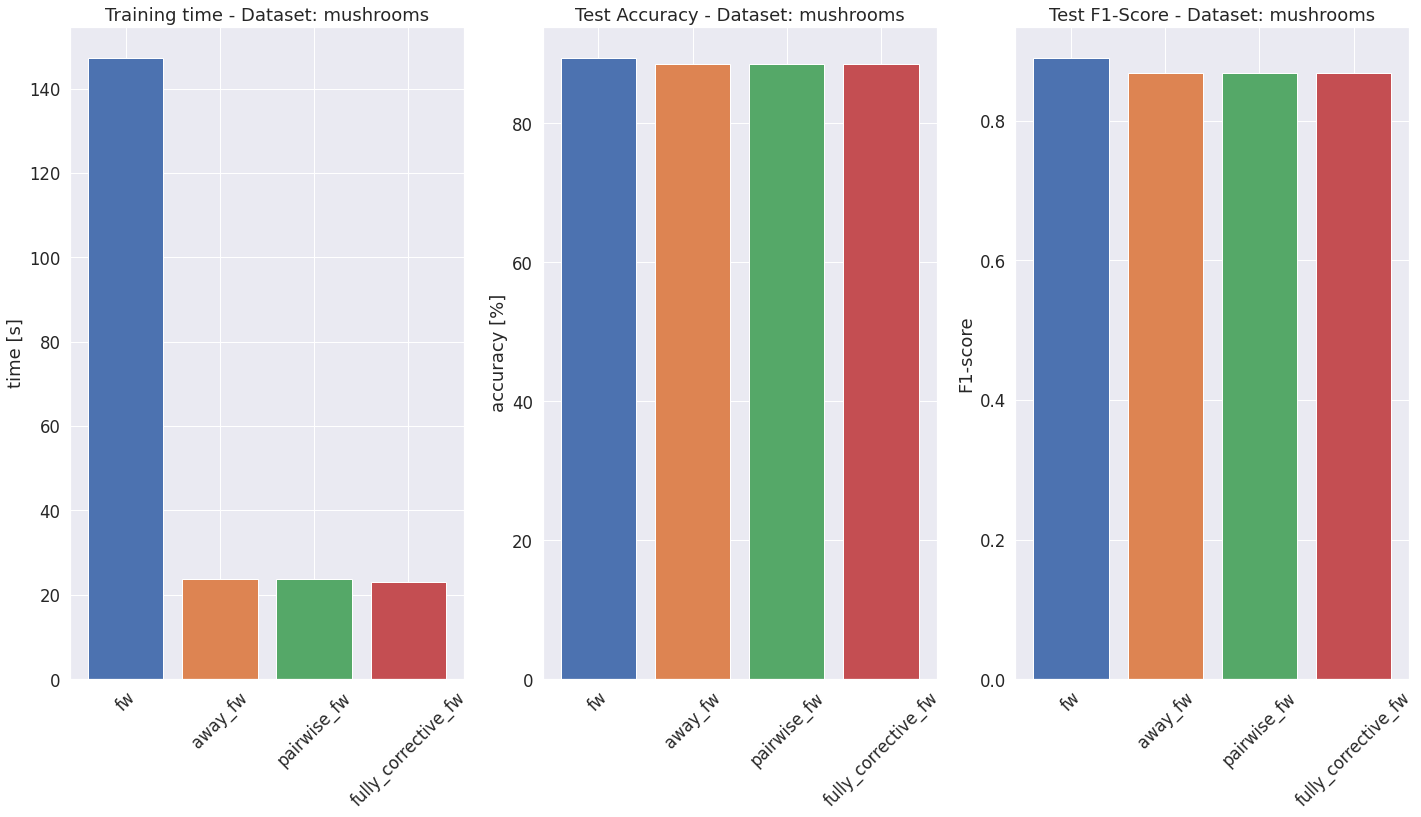

In [ ]:
comparison_dict_mushrooms = compare_methods(X_train, y_train, X_test, y_test, k=30)
plot_methods_comparison("mushrooms", comparison_dict_mushrooms)

### Dataset: phishing
Number of classes: 2

Training Samples: 5527

Test Samples: 5528

Number of features: 68

In [ ]:
# Load the dataset
X, y = load_svmlight_file("/phishing.txt")
X = X.todense()

y[y == 1] = 1
y[y == 0] = -1


# Split it into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

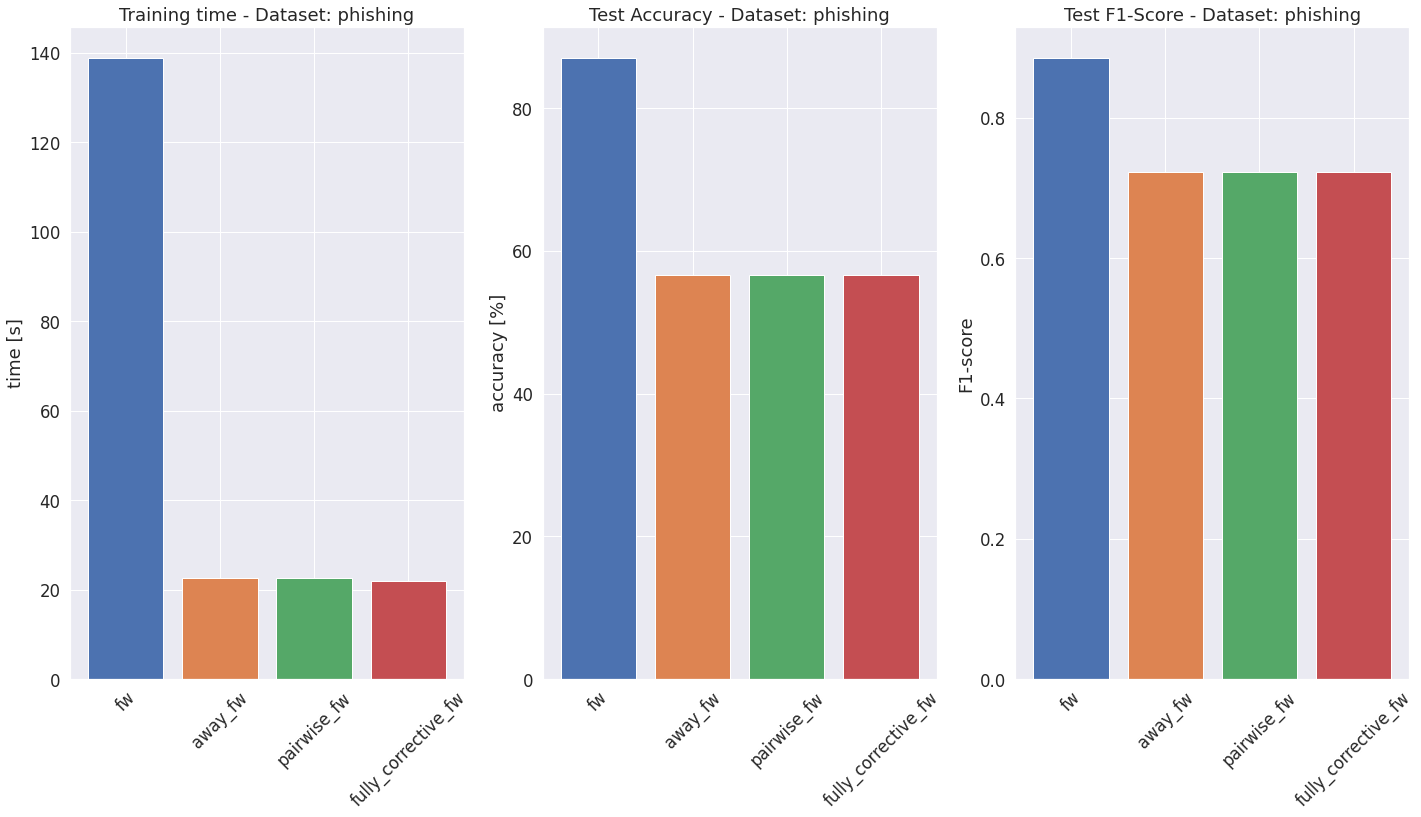

In [ ]:
comparison_dict_phishing = compare_methods(X_train, y_train, X_test, y_test, k=100)
plot_methods_comparison("phishing", comparison_dict_phishing)

### Results

In [ ]:
comparison_dict = {"australian": comparison_dict_australian,
                   "breast_cancer": comparison_dict_cancer,
                   "mushrooms": comparison_dict_mushrooms,
                   "phishing": comparison_dict_phishing}

comparison_df = pd.concat({k: pd.DataFrame(v).T for k, v in comparison_dict.items()}, axis=0)
comparison_df = comparison_df.reset_index()
comparison_df.columns = ["dataset", "method", "training_time", "test_accuracy", "test_f1"]

In [ ]:
round(comparison_df, 2)

,dataset,method,training_time,test_accuracy,test_f1
0,australian,fw,0.31,85.99,0.81
1,australian,away_fw,0.06,86.96,0.85
2,australian,pairwise_fw,0.05,86.96,0.85
3,australian,fully_corrective_fw,0.05,86.96,0.85
4,breast_cancer,fw,0.24,98.05,0.98
5,breast_cancer,away_fw,0.04,97.07,0.98
6,breast_cancer,pairwise_fw,0.03,97.07,0.98
7,breast_cancer,fully_corrective_fw,0.03,97.07,0.98
8,mushrooms,fw,151.92,89.42,0.89
9,mushrooms,away_fw,24.86,88.52,0.87


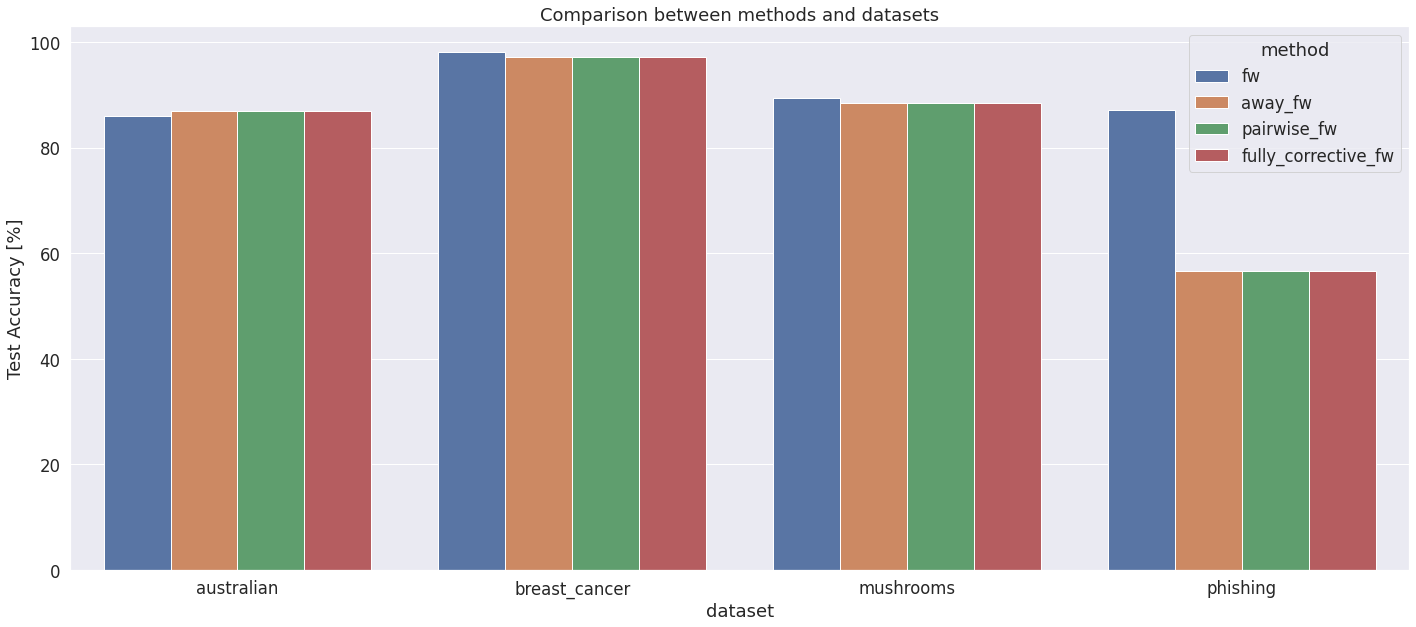

In [ ]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.barplot(x='dataset', y='test_accuracy', hue='method', data=comparison_df)
ax.set_ylabel("Test Accuracy [%]")
ax.set_title("Comparison between methods and datasets")
plt.show()

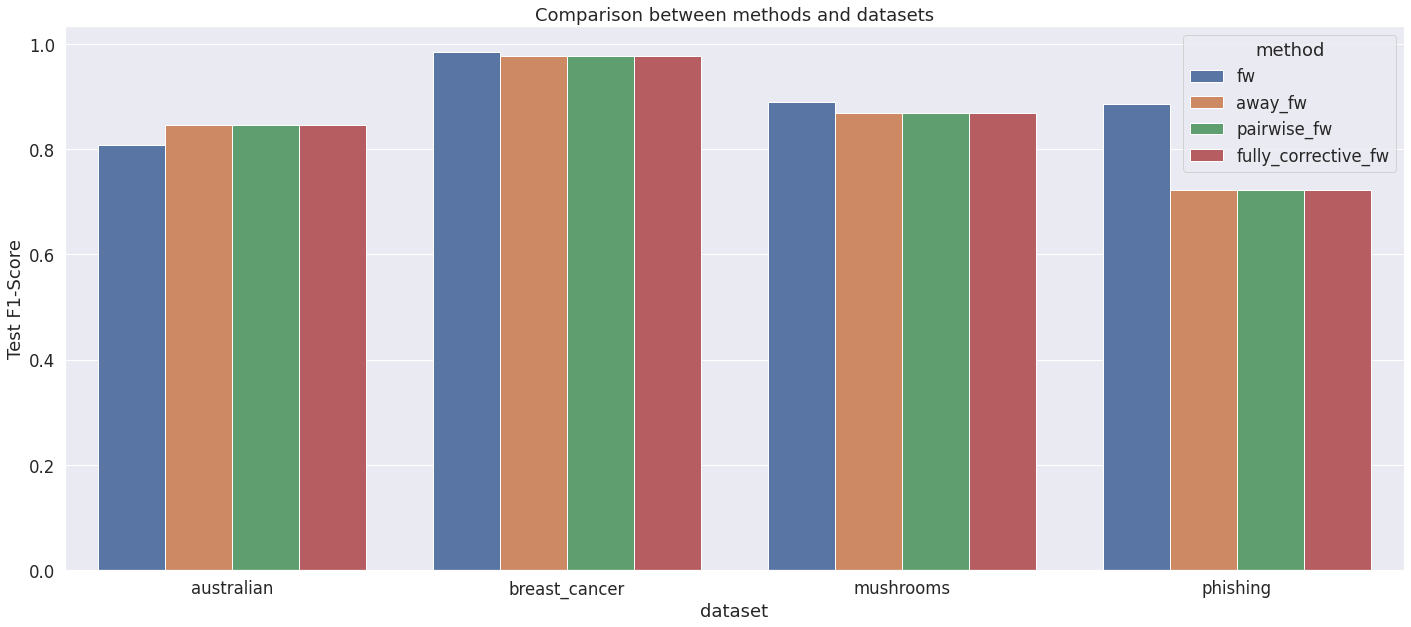

In [ ]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.barplot(x='dataset', y='test_f1', hue='method', data=comparison_df)
ax.set_ylabel("Test F1-Score")
ax.set_title("Comparison between methods and datasets")
plt.show()

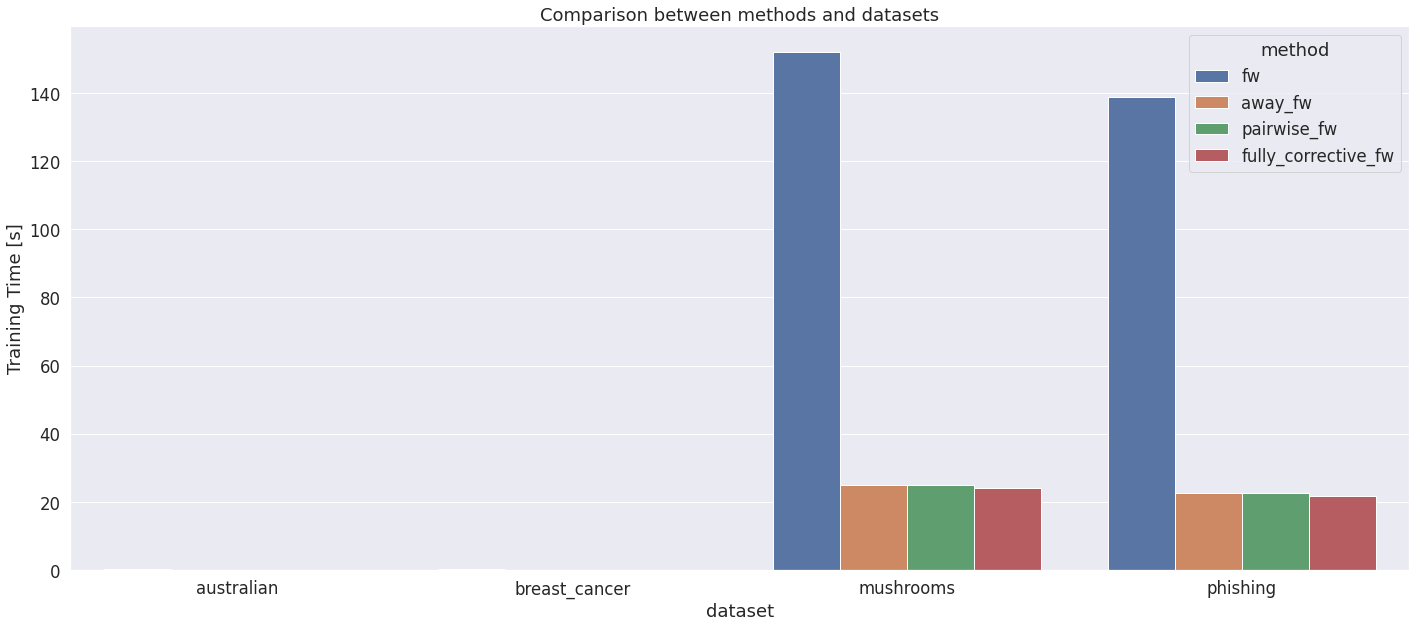

In [ ]:
fig, ax = plt.subplots(figsize=(24, 10))
sns.barplot(x='dataset', y='training_time', hue='method', data=comparison_df)
ax.set_ylabel("Training Time [s]")
ax.set_title("Comparison between methods and datasets")
plt.show()

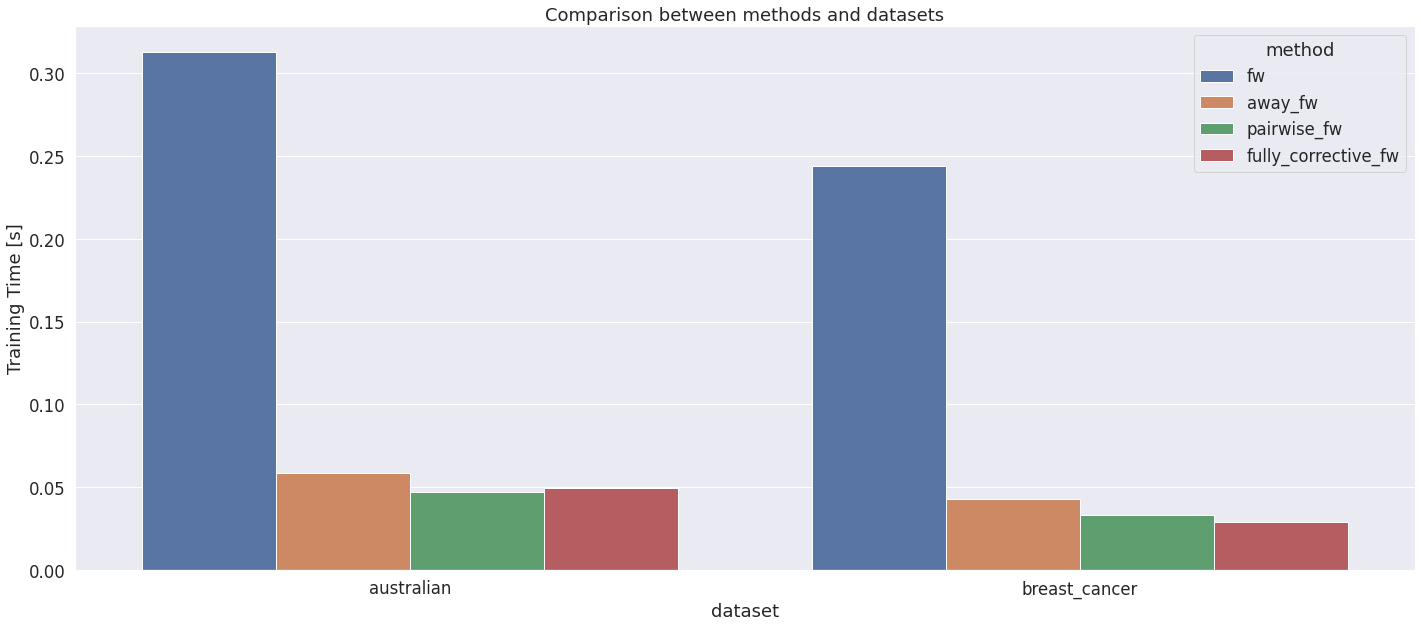

In [ ]:
df1 = comparison_df[(comparison_df.dataset == "australian") | (comparison_df.dataset == "breast_cancer")]

fig, ax = plt.subplots(figsize=(24, 10))
sns.barplot(x='dataset', y='training_time', hue='method', data=df1)
ax.set_ylabel("Training Time [s]")
ax.set_title("Comparison between methods and datasets")
plt.show()

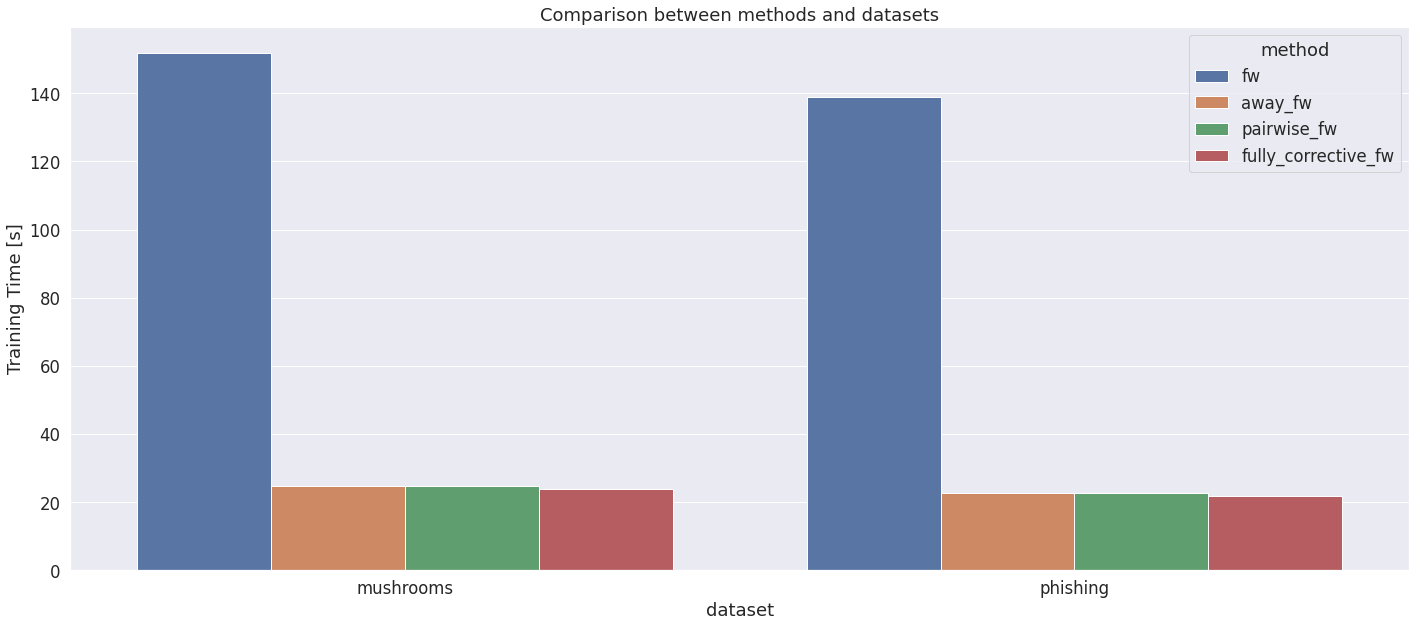

In [ ]:
df2 = comparison_df[(comparison_df.dataset == "mushrooms") | (comparison_df.dataset == "phishing")]

fig, ax = plt.subplots(figsize=(24, 10))
sns.barplot(x='dataset', y='training_time', hue='method', data=df2)
ax.set_ylabel("Training Time [s]")
ax.set_title("Comparison between methods and datasets")
plt.show()